# How to fine-tune an Hugging Face Transformer to transcribe historical documents
First, we mount our Google Drive folder, using the following command.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


The `datasets` module permits to load datasets that have been released to the Hugging Face library. Moreover, it permits to compute metrics to evaluate the models.



In [2]:
!pip install datasets==2.21.0

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.0 MB/s eta 0:00:00


In [4]:
!pip install jiwer

In [5]:
!pip install Levenshtein torch transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 12.8 MB/s eta 0:00:00


In [1]:
import os
from glob import glob
import pandas as pd

In [2]:
import torch
import transformers

from datasets import load_metric

from transformers import TrOCRProcessor, VisionEncoderDecoderModel, Seq2SeqTrainer, \
    Seq2SeqTrainingArguments, default_data_collator

We can use custom Python files that have to be loaded in our Google Drive.  
To do so, we have to append to the `sys.path` the location of the modules/Python files we want to use in the code.

In [3]:
import sys
sys.path.append('/content/gdrive/MyDrive/PyDataPracticeHuggingFace/')

In [5]:
from custom_datasets.htrdataset import *
from utilities.utilities import *

In [6]:
dataset = 'washington'
base_dataset_path = '/content/gdrive/MyDrive/PyDataPracticeHuggingFace/'

dataset_path = os.path.join(base_dataset_path,dataset)
file_dir = 'lines'

In [7]:
list_files_train, list_files_val, list_files_test = [], [], []

with open(os.path.join(dataset_path, 'train.ln')) as f:
    list_files_train = f.readlines()
with open(os.path.join(dataset_path, 'val.ln')) as f:
    list_files_val = f.readlines()
with open(os.path.join(dataset_path, 'test.ln')) as f:
    list_files_test = f.readlines()

path_files = os.path.join(dataset_path,file_dir)
train, val, test = get_partitioned_data(path_files, list_files_train, list_files_val, list_files_test)

list_names_train, list_transcriptions_train = train
list_names_val, list_transcriptions_val = val
list_names_test, list_transcriptions_test = test

In [8]:
train_df = pd.DataFrame({
    'file_name' : list_names_train,
    'text' : list_transcriptions_train
})
val_df = pd.DataFrame({
    'file_name' : list_names_val,
    'text' : list_transcriptions_val
})
test_df = pd.DataFrame({
    'file_name' : list_names_test,
    'text' : list_transcriptions_test
})

Let's see what is inside the datasets. We have stored both the name of the images to transcribe and the transcription itself, too.

In [9]:
train_df.head()

,file_name,text
0,277-15.png,sent Recruiting_ and to Rendezvous at Alexandri+
1,279-26.png,Box]s_ out of those Arms now in Store.
2,275-04.png,that the men of the Virginia Regiment are exer+
3,274-15.png,him immediately. If no other Horses_ belong+
4,277-27.png,Winchester_ you must provide your men with Car+


# Definition of the model to use
We will use the small version of the models released by Microsoft, because the other ones (base and large) cannot be loaded in the free-to-use GPU of Google-Colab.

In [11]:
model = 'microsoft/trocr-base-handwritten'
processor = TrOCRProcessor.from_pretrained(model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


We define a function to compute the metrics to be used to evaluate the performance of the model.  
When evaluating Optical Character Recognition (OCR) or Handwritten Text Recognition (HTR) models, the Charatecter Error Rate (CER) is commonly used.  
It is based on the *Levenshtein* distance.

In [11]:
def compute_metrics(pred):
    #GT/references
    labels_ids = pred.label_ids
    # the predicted ids that corresponds to labels
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

Let's create the output directory where to save the checkpoints/models.

In [28]:
!mkdir '/content/gdrive/MyDrive/PyDataPracticeHuggingFace/models'

In [12]:
train_dataset = HandwritingDataset(root_dir=path_files+'/',
                            df=train_df,
                            processor=processor)
val_dataset = HandwritingDataset(root_dir=path_files+'/',
                        df=val_df,
                        processor=processor)

n_epochs = 5
batch_size = 10

print("Number of train samples:", len(train_dataset))
print("Number of val samples:", len(val_dataset))
print("Number of samples in a batch:", batch_size)
print("Number of epochs:", n_epochs)


out_dir = '/content/gdrive/MyDrive/PyDataPracticeHuggingFace/models'
print("Output directory: ", out_dir)


Number of train samples: 324
Number of val samples: 167
Number of samples in a batch: 10
Number of epochs: 5
Output directory:  /content/gdrive/MyDrive/PyDataPracticeHuggingFace/models


Let's download the model!

In [13]:
model = VisionEncoderDecoderModel.from_pretrained(model)
print('after downloading the model...')

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


after downloading the model...


# Setting the parameters for training

In [14]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 128 # maximum number of tokens to generate
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [15]:
steps_by_epoch = len(train_dataset)//batch_size
steps_in_val = len(val_dataset)//batch_size
print(f'N. training steps by epoch {steps_by_epoch}')
print(f'N. validation steps by epoch {steps_in_val}')

N. training steps by epoch 32
N. validation steps by epoch 16


In [16]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="epoch", #"steps"
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    output_dir=out_dir,
    logging_steps=20,
    save_steps=steps_by_epoch,
    eval_steps=steps_by_epoch,
    num_train_epochs=n_epochs,
    report_to="none"
)

cer_metric = load_metric("cer")

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-16-855225c51c6c>:15: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")
/usr/local/lib/python3.10/dist-packages/transformers/models/trocr/processing_trocr.py:137: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


# Fine-tune the model!

In [17]:
trainer.train()

Epoch,Training Loss,Validation Loss,Cer
1,4.413400,1.520039,0.191999
2,0.861600,1.129711,0.135647
3,0.547300,1.002753,0.117723
4,0.310800,0.761673,0.072555
5,0.095800,0.725827,0.069257


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be

TrainOutput(global_step=165, training_loss=1.0431531526825644, metrics={'train_runtime': 695.9907, 'train_samples_per_second': 2.328, 'train_steps_per_second': 0.237, 'total_flos': 1.2122220094134682e+18, 'train_loss': 1.0431531526825644, 'epoch': 5.0})

# Inference
After having trained the model we can use it for inference on the test dataset.

In [14]:
path_to_checkpoint = '/content/gdrive/MyDrive/PyDataPracticeHuggingFace/models/checkpoint-165'
model = VisionEncoderDecoderModel.from_pretrained(path_to_checkpoint)

In [15]:
test_dataset = HandwritingDataset(root_dir=path_files+'/',
                           df=test_df,
                           processor=processor)

print("Number of test samples:", len(test_dataset))


Number of test samples: 162


In [16]:
cer_metric = load_metric('cer')
wer_metric = load_metric('wer')
model.train(False)
model = model.to('cuda')

In [21]:
tot_cer, tot_wer = 0., 0.
for i in range(len(test_dataset)):
    encoding = test_dataset[i]

    pixel_values = encoding["pixel_values_orig"].to('cuda')

    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    labels = encoding['labels']
    labels[labels == -100] = processor.tokenizer.pad_token_id
    label_str = processor.decode(labels, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=[generated_text], references=[label_str])
    wer = wer_metric.compute(predictions=[generated_text], references=[label_str])
    tot_cer += cer
    tot_wer += wer

tot_cer = (tot_cer/len(test_dataset))*100
tot_wer = (tot_wer/len(test_dataset))*100
print('test cer')
print(round(tot_cer,2))
print('test wer')
print(round(tot_wer,2))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-2edf81670b06>", line 3, in <cell line: 2>
    encoding = test_dataset[i]
  File "/content/gdrive/MyDrive/PyDataPracticeHuggingFace/custom_datasets/htrdataset.py", line 20, in __getitem__
    image = Image.open(self.root_dir + file_name).convert("RGB")
  File "/usr/local/lib/python3.10/dist-packages/PIL/Image.py", line 3442, in open
    prefix = fp.read(16)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

TypeError: object of type 'NoneType' has no len()

In [38]:
import matplotlib.pyplot as plt

In [55]:
def eval_new_data(data_path=None, num_samples=4, model=None, device = 'cuda'):
    image_paths = glob(data_path+'/*.png')

    for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
        # read the gt
        with open(image_path[:-3]+'txt') as f:
          gt = f.readline()

        if i == num_samples:
            break

        image = read_image(image_path)
        text = ocr(image, processor, model, device)
        print('\n\tGT: ' + gt)
        print('Prediction: ' + text)
        plt.figure(figsize=(7, 4))
        plt.imshow(image)
        plt.axis('off')
        plt.show()

  0%|          | 0/657 [00:00<?, ?it/s]


	GT: 24. To Sergeant Campbell_ of the Virginia Regiment.
Prediction: 5^. To Sergeant Campbell_ of the Virginia Regiment.


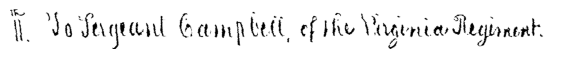

  0%|          | 1/657 [00:00<09:13,  1.18it/s]


	GT: sent Recruiting_ and to Rendezvous at Alexandri+
Prediction: sent Recruiting_ and to Rendezvous at Alexandri+


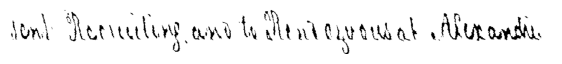

  0%|          | 2/657 [00:01<09:17,  1.18it/s]


	GT: Stores and medicines arrives_ you are to embrace
Prediction:  Stores and medicines arrives_ you are to embrace


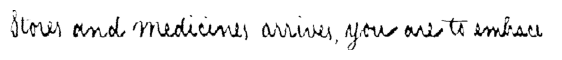

  0%|          | 3/657 [00:02<09:31,  1.14it/s]


	GT: Box]s_ out of those Arms now in Store.
Prediction: Box]s_ out of those Arms now in Store.


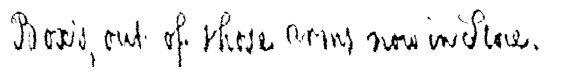

  1%|          | 4/657 [00:03<09:39,  1.13it/s]


In [56]:
eval_new_data(data_path=path_files, model=model)